In [1]:
import os
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from models.ResUNet import ResUNet
from models.DUBLID import DUBLID

%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/tianaoli/.conda/envs/pact/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load in Test Data

In [2]:
data_path = '/mnt/WD6TB/tianaoli/dataset/SkinVessel_PACT/test/'
idx = 10000
gt = torch.from_numpy(np.load(os.path.join(data_path, 'gt', f"gt_{idx}.npy"))).float()
obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx}.npy"))).float()

### Load the Model

In [3]:
model = ResUNet(in_nc=8, out_nc=1)
pretrained_epochs = 46
loss = 'MSE'
pretrained_file = os.path.join('../saved_models/', f'ResUNet_{loss}_{pretrained_epochs}epochs.pth')
model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
print('Successfully loaded in %s.', pretrained_file)

Successfully loaded in %s. ../saved_models/ResUNet_MSE_46epochs.pth


In [4]:
# model = DUBLID(device=device, channels=1)
# pretrained_file = os.path.join('../saved_models/', f'DUBLID_MSE_16epochs.pth')
# model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
# print('Successfully loaded in %s.', pretrained_file)

### Deconvolution

In [5]:
model.eval()
obs.to(device)
rec = model(obs.unsqueeze(0))
rec = rec.squeeze(0).squeeze(0).detach()
psf = ifft2(fft2(obs[3])/fft2(rec)).real
print(rec.shape)

torch.Size([128, 128])


(-0.5, 127.5, 127.5, -0.5)

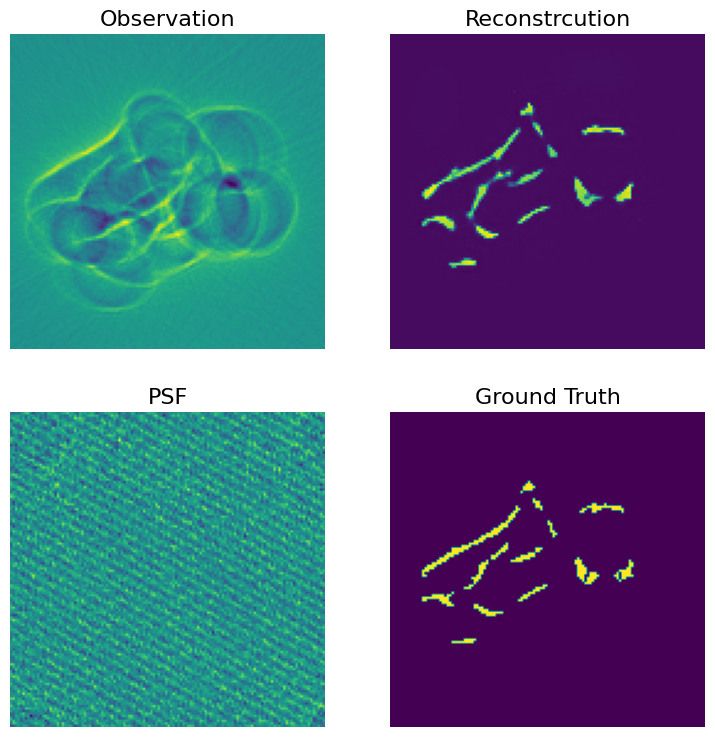

In [6]:
plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.imshow(obs[3])
# plt.imshow(ifft2(fft2(psf)*fft2(gt)).real)
plt.title('Observation', fontsize=16)
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(rec)
plt.title('Reconstrcution', fontsize=16)
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(psf)
plt.title('PSF', fontsize=16)
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(gt)
plt.title('Ground Truth', fontsize=16)
plt.axis('off')